# import modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
# light blue and orange
correct_color = "tab:blue"
incorrect_color = "tab:orange"

/home/nakagawa/.local/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# define functions

In [2]:
def calc_accuracy(df):
    return (df['true_label'] == df['predict_label']).sum() / len(df)

def preprocess_df(raw_df:pd.DataFrame, true_label:pd.DataFrame)->pd.DataFrame:
    df = raw_df.copy()
    LABELS = ["Downstairs", "Jogging", "Sitting", "Standing", "Upstairs", "Walking"]
    min_max_func = lambda x: (x - x.min()) / (x.max() - x.min()) # min-max normalization
    convert_probability_func = lambda x: x / x.sum() # convert to binary
    processed_df = df.apply(min_max_func, axis=1).apply(convert_probability_func, axis=1)
    processed_df.columns = LABELS
    processed_df["predict_probability"] = processed_df.max(axis=1)
    processed_df["predict_label"] = processed_df.idxmax(axis=1)
    processed_df['true_label'] = true_label.map(lambda x: LABELS[x])
    return processed_df

def show_count(processed_df, title):
    df = processed_df.copy()
    acc = calc_accuracy(df)
    df.loc[df.true_label==df.predict_label,"correct"] = df.loc[df.true_label==df.predict_label, 'predict_probability']
    df.loc[df.true_label!=df.predict_label, 'incorrect'] = df.loc[df.true_label!=df.predict_label, 'predict_probability']
    df.loc[:,['incorrect', 'correct',]].plot.hist(bins=100, stacked=True, color=[incorrect_color, correct_color])
    plt.title(f'{title}\nPredict Probability Count\nACC: {acc:.4f}')
    plt.xlim(0, 1)
    plt.ylim(0, 400)
    plt.xlabel('Probability')
    plt.ylabel('Count')
    plt.legend(['Incorrect', 'Correct'])
    plt.savefig(f'assets/{title}-count.png')
    plt.show()

def show_count_stacked(processed_df, title, split_size=0.01):
    df = processed_df.copy()
    acc = calc_accuracy(df)
    df.loc[df.true_label==df.predict_label,"correct"] = df.loc[df.true_label==df.predict_label, 'predict_probability']
    df.loc[df.true_label!=df.predict_label, 'incorrect'] = df.loc[df.true_label!=df.predict_label, 'predict_probability']
    df = df.loc[:,['incorrect', 'correct',]]
    correct_list = list()
    incorrect_list = list()
    split_num = int(1/split_size)
    for i in range(split_num,0,-1):
        i *= split_size
        correct_list.append((df.correct>i).sum())
        incorrect_list.append((df.incorrect>i).sum())
    correct_list.reverse()
    incorrect_list.reverse()
    plt.bar(np.arange(split_num)*split_size, incorrect_list, width=split_size, color=incorrect_color)
    plt.bar(np.arange(split_num)*split_size, correct_list, width=split_size, color=correct_color, bottom=incorrect_list)
    plt.title(f'{title}\nPredict Probability Stacked Count\nACC: {acc:.4f}')
    plt.xlim(0,1)
    plt.xlabel('Probability')
    plt.ylabel('Count')
    plt.legend(['Incorrect', 'Correct'])
    plt.savefig(f'assets/{title}-count-stacked.png')
    plt.show()

def show_confusion_matrix(df, title):
    LABELS = ["Downstairs", "Jogging", "Sitting", "Standing", "Upstairs", "Walking"]
    cm = confusion_matrix(df['true_label'], df['predict_label'], labels=LABELS)
    plt.figure(figsize=(10,10))
    sns.heatmap(cm, annot=True, cmap=plt.cm.Blues, xticklabels=LABELS, yticklabels=LABELS)
    plt.title(f'{title}\nConfusion Matrix\nACC: {calc_accuracy(df):.4f}')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.savefig(f'assets/{title}-confusion-matrix.png')
    plt.show()

def calc_thredshold_df(df):
    thresholds = [i*0.1 for i in range(11)]
    acc_list = list()
    count_list = list()
    for threshold in thresholds:
        acc_list.append(calc_accuracy(df.loc[df.predict_probability>threshold]))
        count_list.append(len(df.loc[df.predict_probability>threshold]))
    threshold_df = pd.DataFrame({'threshold': thresholds, 'accuracy': acc_list, 'count': count_list})
    return threshold_df.set_index('threshold')

# load data

In [3]:
convbbt_seed314_raw_df = pd.read_csv('../convbbt/predict.csv', index_col=0).drop(columns=["true"])
convbbt_seed412_raw_df = pd.read_csv('../convbbt-seed:412/predict.csv', index_col=0).drop(columns=["true"])
convbbt_seed752_raw_df = pd.read_csv('../convbbt-seed:752/predict.csv', index_col=0).drop(columns=["true"])
true_label = pd.read_csv('../convbbt/predict.csv', index_col=0)["true"]

# check data

## raw data head

In [4]:
convbbt_seed314_raw_df.head()

,0,1,2,3,4,5
0,2.667278,-6.223639,-10.455910,-7.705863,3.942457,5.992100
1,-3.501386,-5.147262,15.075128,7.256400,-0.475929,-2.861587
2,3.822823,-9.720933,-9.241361,-5.683146,6.891798,3.425873
3,3.279096,11.735168,-4.228587,-1.351361,-4.169562,-4.644408
4,-2.105618,-2.101908,0.199927,13.780579,-3.819936,-1.524870


In [5]:
convbbt_seed412_raw_df.head()

,0,1,2,3,4,5
0,-0.051365,-6.140929,-5.497334,-5.696781,-0.642313,13.210702
1,-1.509786,-8.522696,14.942570,2.538199,-1.973984,-0.270892
2,0.835547,-7.029146,-9.856510,-3.872520,7.731555,3.101007
3,2.742987,15.359550,-0.604864,-5.680943,-6.409413,-4.199465
4,-4.779817,-3.136304,-3.719555,13.347833,0.276563,-0.086556


In [6]:
convbbt_seed752_raw_df.head()

,0,1,2,3,4,5
0,-0.357917,-6.289483,-7.573329,-3.273109,-0.047841,9.462104
1,-3.835415,0.232564,15.567179,5.952334,-1.411911,-4.395430
2,-4.000293,-5.686593,-9.716810,-6.585641,7.205666,5.940221
3,-0.476328,16.827456,-0.997094,-4.125641,-3.252111,-1.890935
4,-0.033632,-1.931396,1.993589,14.743385,-6.337326,-0.032644


In [7]:
convbbt_seed314_df = preprocess_df(convbbt_seed314_raw_df, true_label)
convbbt_seed412_df = preprocess_df(convbbt_seed412_raw_df, true_label)
convbbt_seed752_df = preprocess_df(convbbt_seed752_raw_df, true_label)

## processed data head

In [8]:
convbbt_seed314_df.head()

,Downstairs,Jogging,Sitting,Standing,Upstairs,Walking,predict_probability,predict_label,true_label
0,0.257560,0.083064,0.000000,0.053973,0.282588,0.322815,0.322815,Walking,Walking
1,0.039920,0.000000,0.490490,0.300848,0.113302,0.055439,0.490490,Sitting,Sitting
2,0.283220,0.000000,0.010029,0.084436,0.347397,0.274919,0.347397,Upstairs,Upstairs
3,0.278147,0.574988,0.014597,0.115599,0.016669,0.000000,0.574988,Jogging,Jogging
4,0.062686,0.062821,0.146990,0.643581,0.000000,0.083921,0.643581,Standing,Standing


In [9]:
convbbt_seed412_df.head()

,Downstairs,Jogging,Sitting,Standing,Upstairs,Walking,predict_probability,predict_label,true_label
0,0.190135,0.000000,0.020095,0.013868,0.171684,0.604218,0.604218,Walking,Walking
1,0.124476,0.000000,0.416497,0.196325,0.116236,0.146465,0.416497,Sitting,Sitting
2,0.213632,0.056492,0.000000,0.119563,0.351417,0.258897,0.351417,Upstairs,Upstairs
3,0.230746,0.548830,0.146342,0.018366,0.000000,0.055716,0.548830,Jogging,Jogging
4,0.000000,0.053743,0.034671,0.592774,0.165343,0.153470,0.592774,Standing,Standing


In [10]:
convbbt_seed752_df.head()

,Downstairs,Jogging,Sitting,Standing,Upstairs,Walking,predict_probability,predict_label,true_label
0,0.193130,0.034364,0.000000,0.115101,0.201430,0.455976,0.455976,Walking,Walking
1,0.014553,0.120264,0.518753,0.268900,0.077530,0.000000,0.518753,Sitting,Sitting
2,0.125755,0.088659,0.000000,0.068881,0.372271,0.344433,0.372271,Upstairs,Upstairs
3,0.118334,0.679431,0.101447,0.000000,0.028325,0.072463,0.679431,Jogging,Jogging
4,0.135780,0.094902,0.179445,0.454072,0.000000,0.135801,0.454072,Standing,Standing


# Each Model

# frequency of each model

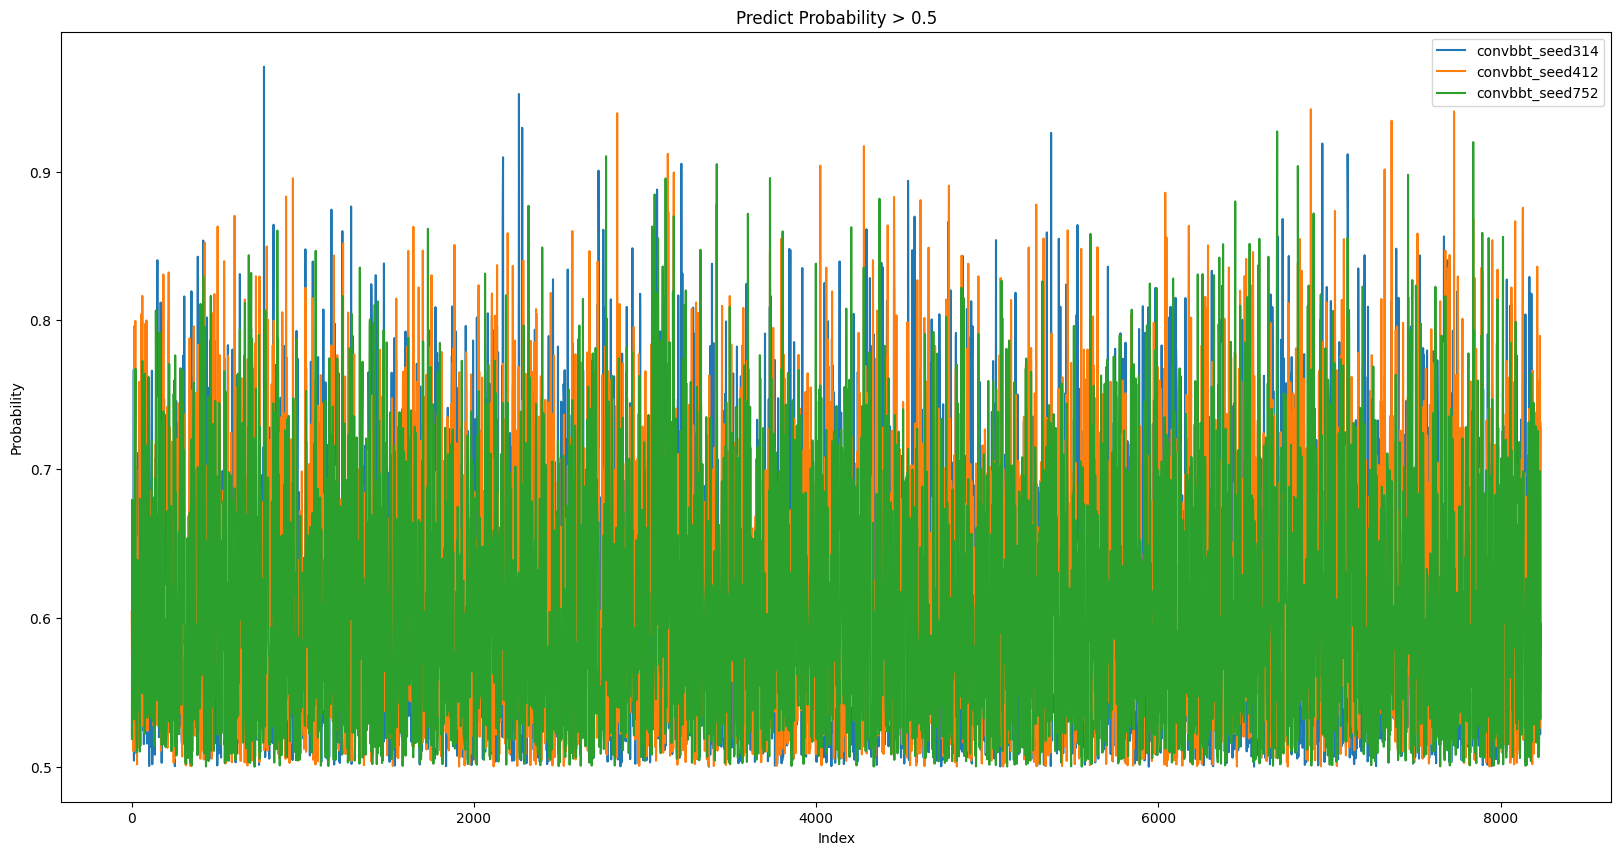

In [11]:
plt.rcParams['figure.figsize'] = [20, 10]
threshold = 0.5
convbbt_seed314_df.loc[convbbt_seed314_df.predict_probability>threshold,'predict_probability'].plot()
convbbt_seed412_df.loc[convbbt_seed412_df.predict_probability>threshold,'predict_probability'].plot()
convbbt_seed752_df.loc[convbbt_seed752_df.predict_probability>threshold,'predict_probability'].plot()
plt.title(f'Predict Probability > {threshold}')
plt.xlabel('Index')
plt.ylabel('Probability')
plt.legend(['convbbt_seed314', 'convbbt_seed412', 'convbbt_seed752'])

## count

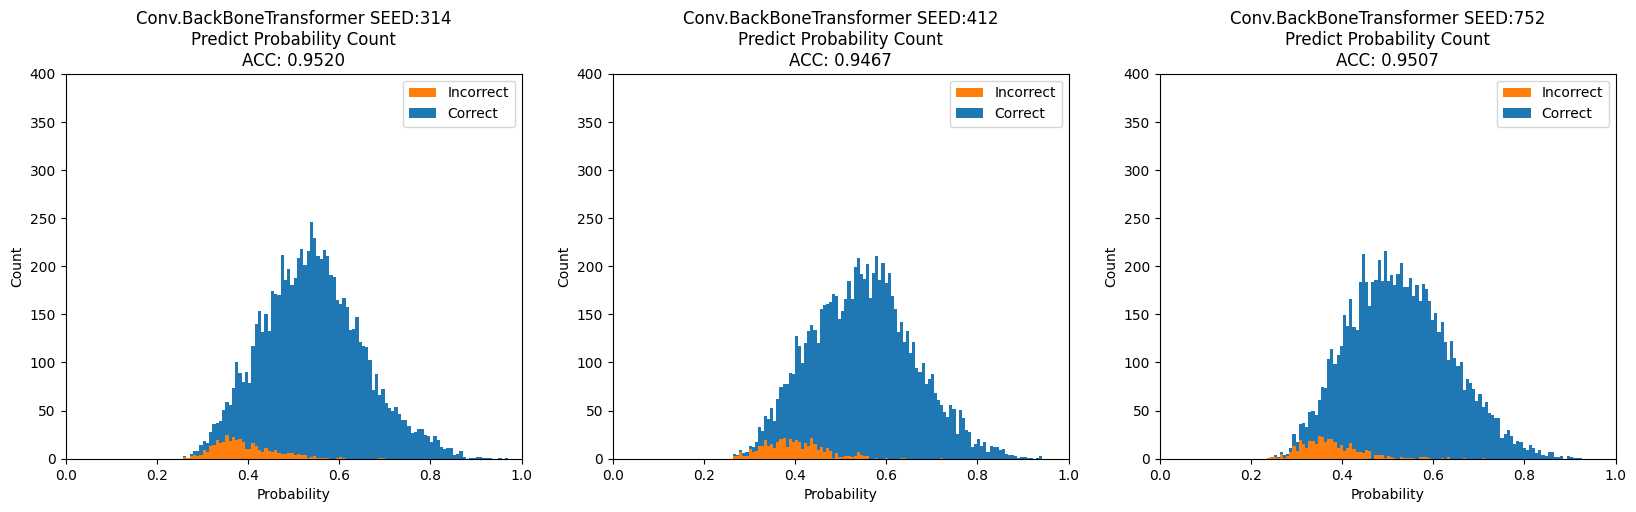

In [12]:
# 3枚描画空間を確保
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
x_limit = (0, 1)
y_limit = (0, 400)
x_label = 'Probability'
y_label = 'Count'
legend = ['Incorrect', 'Correct']
# 1枚目の描画空間に描画
title = "Conv.BackBoneTransformer SEED:314"
df = convbbt_seed314_df.copy()
acc = calc_accuracy(df)
df.loc[df.true_label==df.predict_label,"correct"] = df.loc[df.true_label==df.predict_label, 'predict_probability']
df.loc[df.true_label!=df.predict_label, 'incorrect'] = df.loc[df.true_label!=df.predict_label, 'predict_probability']
df.loc[:,['incorrect', 'correct',]].plot.hist(bins=100, stacked=True, color=[incorrect_color, correct_color], ax=axes[0])
axes[0].set(
    title=f'{title}\nPredict Probability Count\nACC: {acc:.4f}',
    xlim=x_limit,
    ylim=y_limit,
    xlabel=x_label,
    ylabel=y_label,
)
axes[0].legend(legend)
# 2枚目の描画空間に描画
title = 'Conv.BackBoneTransformer SEED:412'
df = convbbt_seed412_df.copy()
acc = calc_accuracy(df)
df.loc[df.true_label==df.predict_label,"correct"] = df.loc[df.true_label==df.predict_label, 'predict_probability']
df.loc[df.true_label!=df.predict_label, 'incorrect'] = df.loc[df.true_label!=df.predict_label, 'predict_probability']
df.loc[:,['incorrect', 'correct',]].plot.hist(bins=100, stacked=True, color=[incorrect_color, correct_color], ax=axes[1])
axes[1].set(
    title=f'{title}\nPredict Probability Count\nACC: {acc:.4f}',
    xlim=x_limit,
    ylim=y_limit,
    xlabel=x_label,
    ylabel=y_label,
)
axes[1].legend(legend)
# 3枚目の描画空間に描画
title = 'Conv.BackBoneTransformer SEED:752'
df = convbbt_seed752_df.copy()
acc = calc_accuracy(df)
df.loc[df.true_label==df.predict_label,"correct"] = df.loc[df.true_label==df.predict_label, 'predict_probability']
df.loc[df.true_label!=df.predict_label, 'incorrect'] = df.loc[df.true_label!=df.predict_label, 'predict_probability']
df.loc[:,['incorrect', 'correct',]].plot.hist(bins=100, stacked=True, color=[incorrect_color, correct_color], ax=axes[2])
axes[2].set(
    title=f'{title}\nPredict Probability Count\nACC: {acc:.4f}',
    xlim=x_limit,
    ylim=y_limit,
    xlabel=x_label,
    ylabel=y_label,
)
axes[2].legend(legend)

plt.show()

## Stacked Count

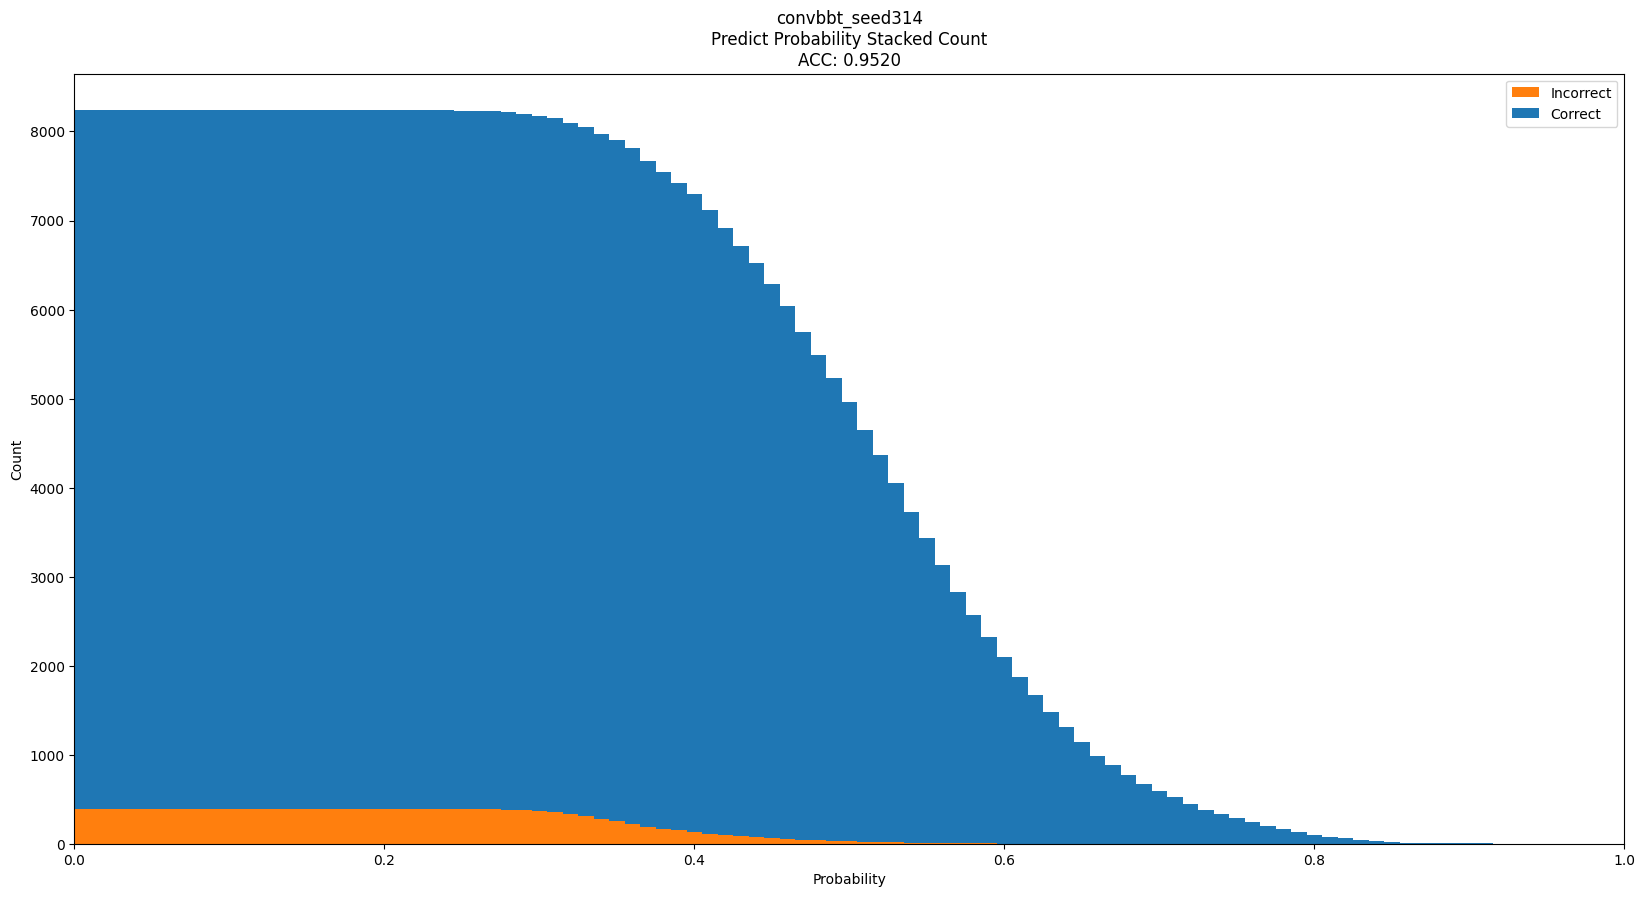

In [13]:
show_count_stacked(convbbt_seed314_df, 'convbbt_seed314')

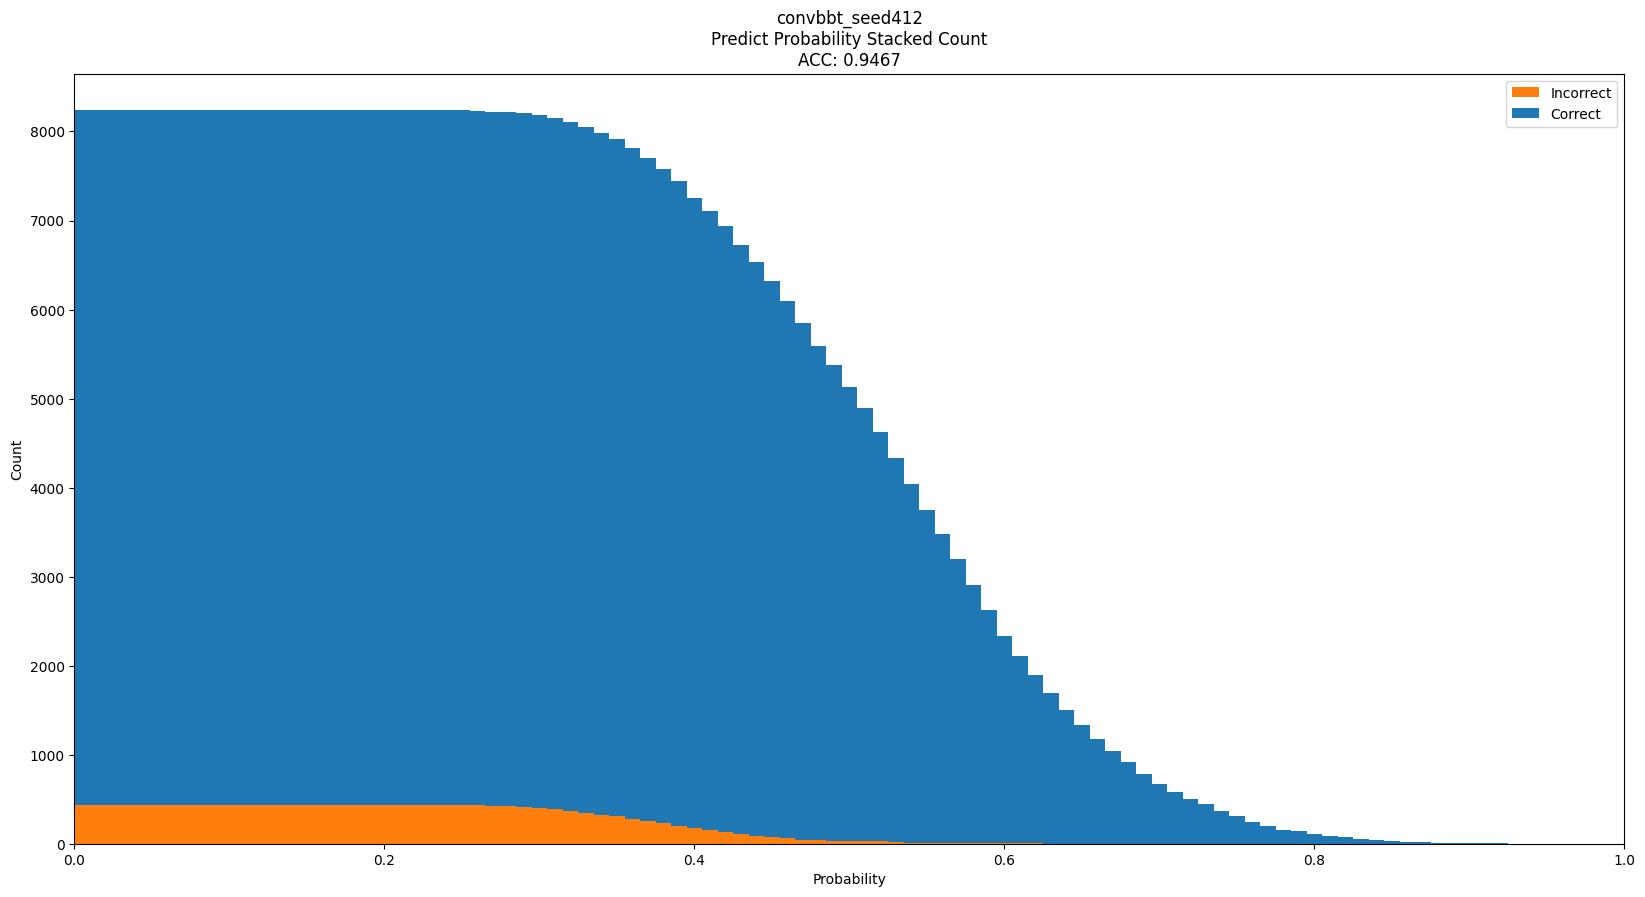

In [14]:
show_count_stacked(convbbt_seed412_df, 'convbbt_seed412')

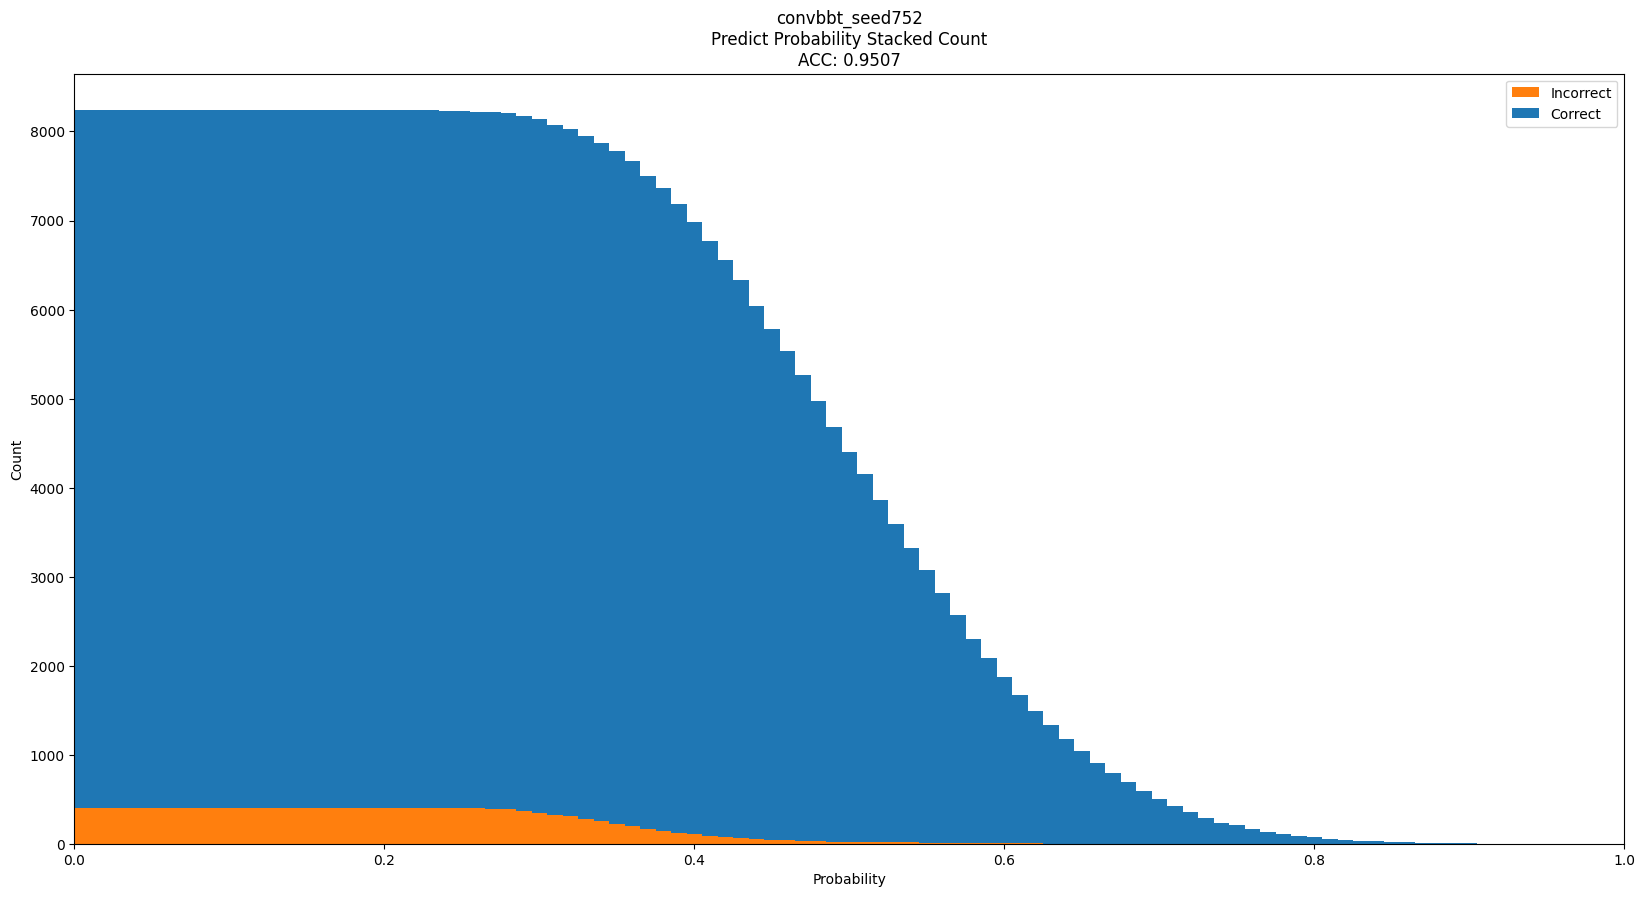

In [15]:
show_count_stacked(convbbt_seed752_df, 'convbbt_seed752')

# Each Model's Result Analysis

In [16]:
convbbt_seed314_correct_index = convbbt_seed314_df.loc[convbbt_seed314_df.true_label==convbbt_seed314_df.predict_label].index
convbbt_seed412_correct_index = convbbt_seed412_df.loc[convbbt_seed412_df.true_label==convbbt_seed412_df.predict_label].index
convbbt_seed752_correct_index = convbbt_seed752_df.loc[convbbt_seed752_df.true_label==convbbt_seed752_df.predict_label].index

convbbt_seed314_incorrect_index = convbbt_seed314_df.loc[convbbt_seed314_df.true_label!=convbbt_seed314_df.predict_label].index
convbbt_seed412_incorrect_index = convbbt_seed412_df.loc[convbbt_seed412_df.true_label!=convbbt_seed412_df.predict_label].index
convbbt_seed752_incorrect_index = convbbt_seed752_df.loc[convbbt_seed752_df.true_label!=convbbt_seed752_df.predict_label].index

all_correct_index = list(set(convbbt_seed314_correct_index)& set(convbbt_seed314_correct_index) & set(convbbt_seed314_correct_index))
all_incorrect_index = list(set(convbbt_seed314_incorrect_index) & set(convbbt_seed412_incorrect_index) & set(convbbt_seed752_incorrect_index))

print(f'All index num: {len(convbbt_seed314_df)}')
print(f'All correct index num: {len(all_correct_index)}')
print(f'All incorrect index num: {len(all_incorrect_index)}')
print(f'ideal accuracy: {1-len(all_incorrect_index)/len(convbbt_seed314_df):.4f}')
print("-"*50 )
print("All incorrect index label count:")
convbbt_seed314_df.loc[all_incorrect_index,"true_label"].value_counts()

All index num: 8237
All correct index num: 7842
All incorrect index num: 129
ideal accuracy: 0.9843
--------------------------------------------------
All incorrect index label count:


Upstairs      50
Downstairs    36
Walking       17
Jogging       16
Standing       6
Sitting        4
Name: true_label, dtype: int64

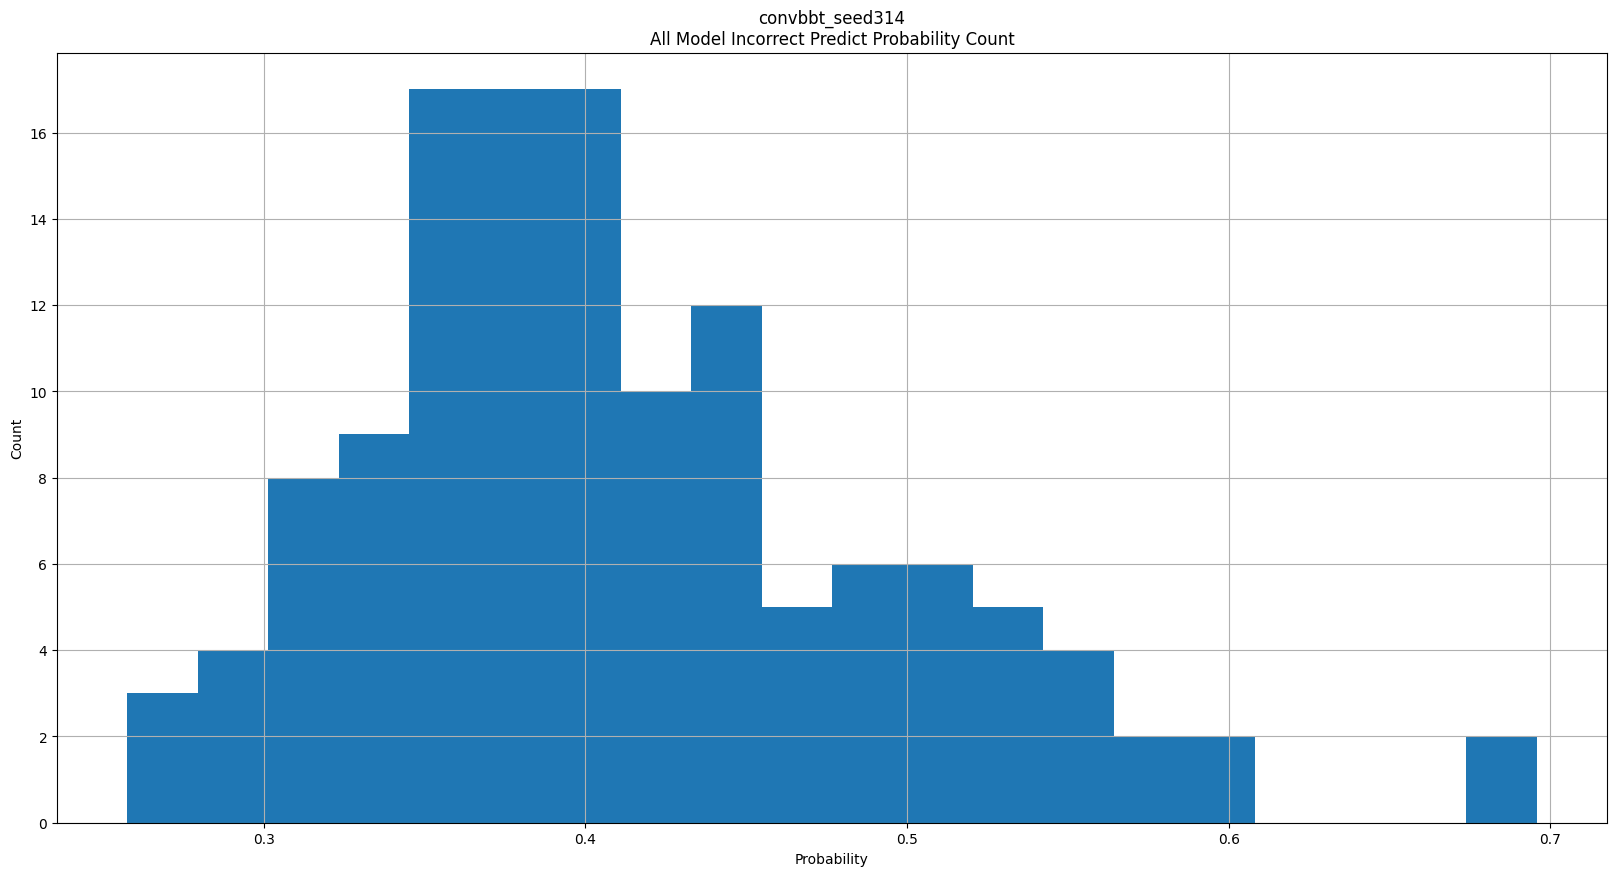

Upstairs      47
Downstairs    33
Walking       29
Jogging       17
Standing       3
Name: predict_label, dtype: int64

In [17]:
convbbt_seed314_df.loc[all_incorrect_index,"predict_probability"].hist(bins=20)
plt.title('convbbt_seed314\nAll Model Incorrect Predict Probability Count')
plt.xlabel('Probability')
plt.ylabel('Count')
plt.show()
convbbt_seed314_df.loc[all_incorrect_index,"predict_label"].value_counts()

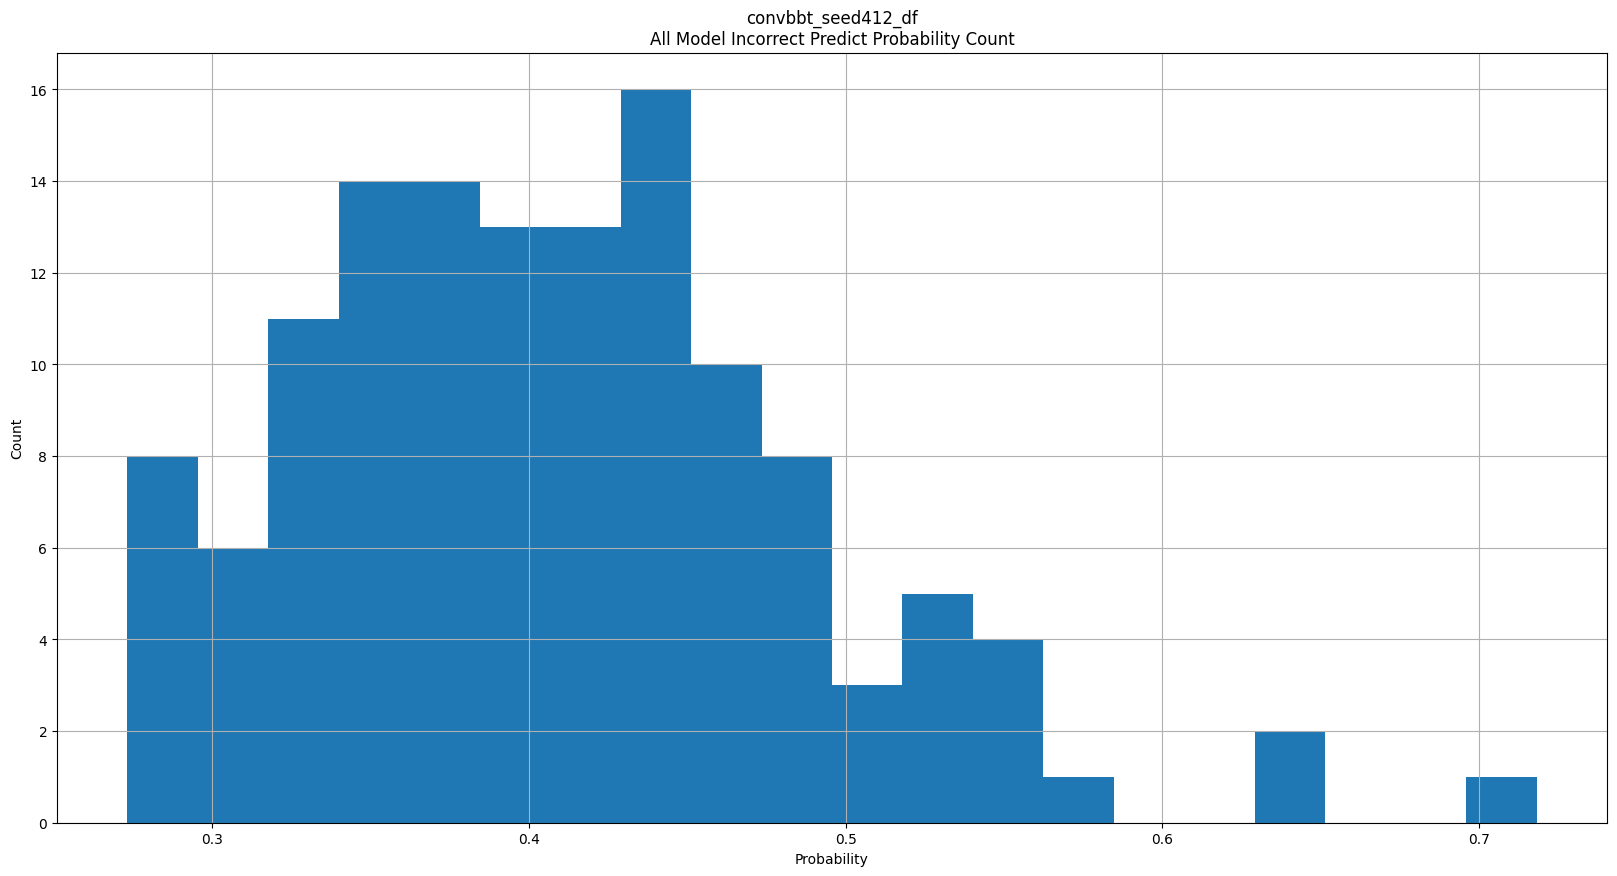

Upstairs      45
Downstairs    38
Walking       27
Jogging       17
Standing       2
Name: predict_label, dtype: int64

In [18]:
convbbt_seed412_df.loc[all_incorrect_index,"predict_probability"].hist(bins=20)
plt.title('convbbt_seed412_df\nAll Model Incorrect Predict Probability Count')
plt.xlabel('Probability')
plt.ylabel('Count')
plt.show()
convbbt_seed412_df.loc[all_incorrect_index,"predict_label"].value_counts()

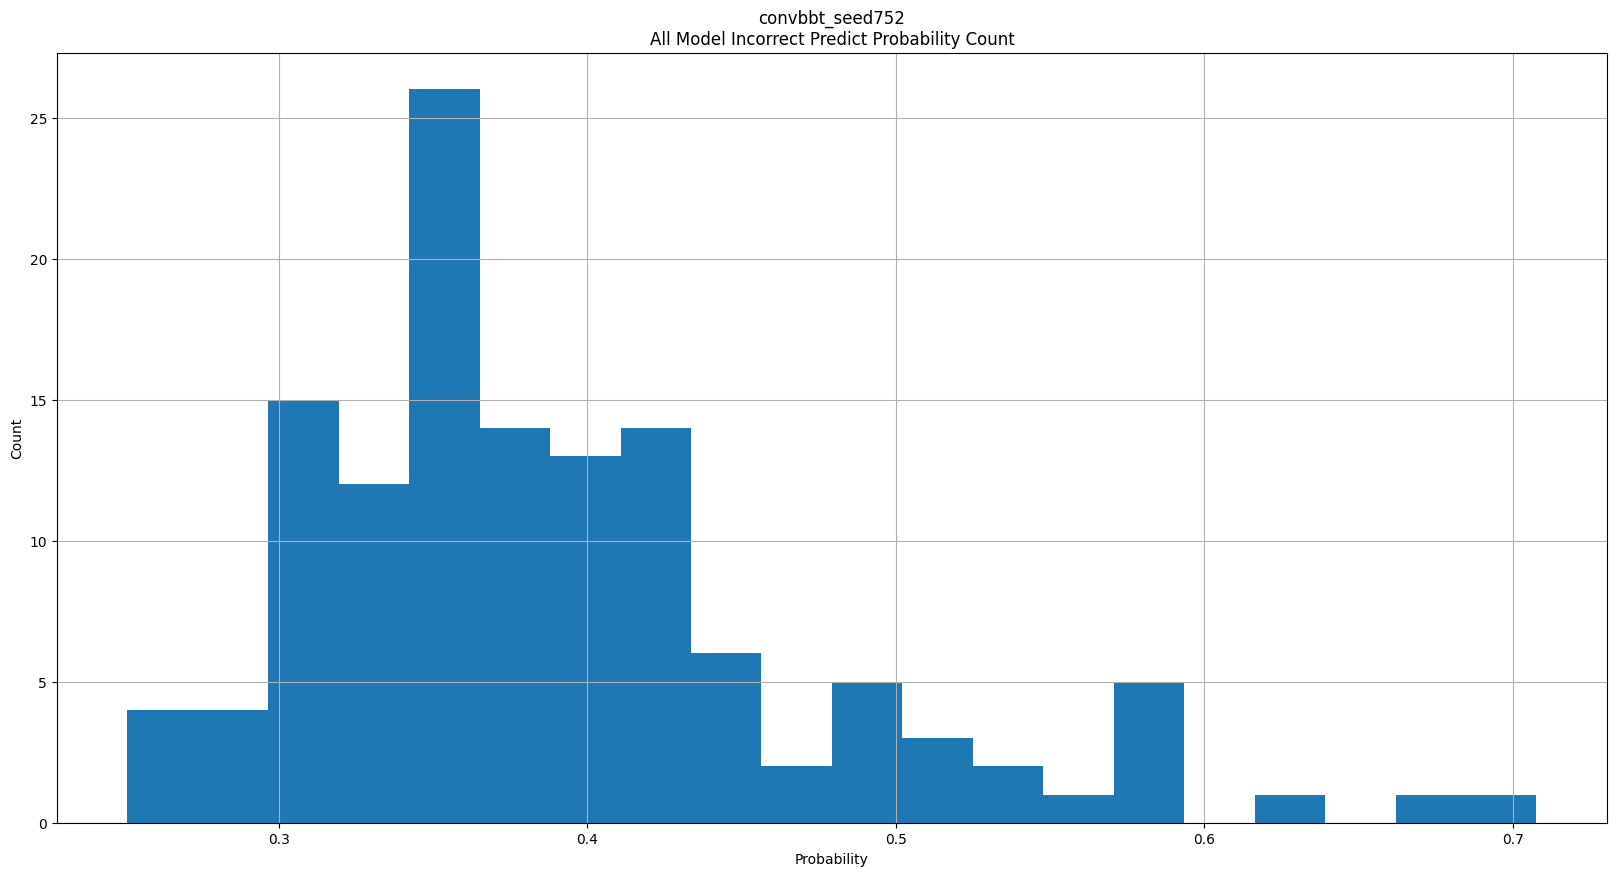

Upstairs      48
Walking       32
Downstairs    25
Jogging       21
Standing       3
Name: predict_label, dtype: int64

In [19]:
convbbt_seed752_df.loc[all_incorrect_index,"predict_probability"].hist(bins=20)
plt.title('convbbt_seed752\nAll Model Incorrect Predict Probability Count')
plt.xlabel('Probability')
plt.ylabel('Count')
plt.show()
convbbt_seed752_df.loc[all_incorrect_index,"predict_label"].value_counts()

# Ensamble Model

## 1. Sum of Probabilities Ensamble

In [20]:
ensamble1_name = 'Sum-of-Probability-Ensamble'

In [21]:
LABELS = ["Downstairs", "Jogging", "Sitting", "Standing", "Upstairs", "Walking"]
ensamble1_df = convbbt_seed314_df.loc[:, LABELS].copy() + convbbt_seed412_df.loc[:, LABELS].copy() + convbbt_seed752_df.loc[:, LABELS].copy()
ensamble1_df = ensamble1_df.apply(lambda x: x / x.sum(), axis=1)
ensamble1_df["predict_probability"] = ensamble1_df.max(axis=1)
ensamble1_df["predict_label"] = ensamble1_df.idxmax(axis=1)
ensamble1_df['true_label'] = true_label.map(lambda x: LABELS[x])

In [22]:
ensamble1_df.head()

,Downstairs,Jogging,Sitting,Standing,Upstairs,Walking,predict_probability,predict_label,true_label
0,0.213609,0.039143,0.006698,0.060981,0.218567,0.461003,0.461003,Walking,Walking
1,0.059650,0.040088,0.475247,0.255358,0.102356,0.067301,0.475247,Sitting,Sitting
2,0.207536,0.048384,0.003343,0.090960,0.357028,0.292750,0.357028,Upstairs,Upstairs
3,0.209076,0.601083,0.087462,0.044655,0.014998,0.042726,0.601083,Jogging,Jogging
4,0.066155,0.070489,0.120369,0.563475,0.055114,0.124397,0.563475,Standing,Standing


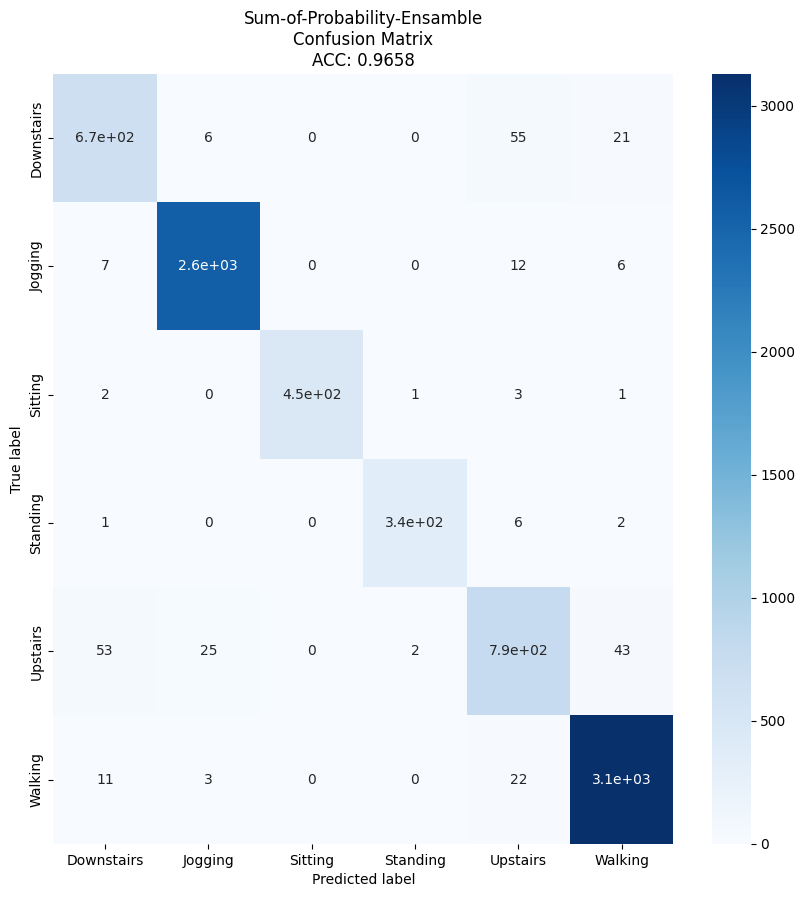

In [23]:
show_confusion_matrix(ensamble1_df, ensamble1_name)

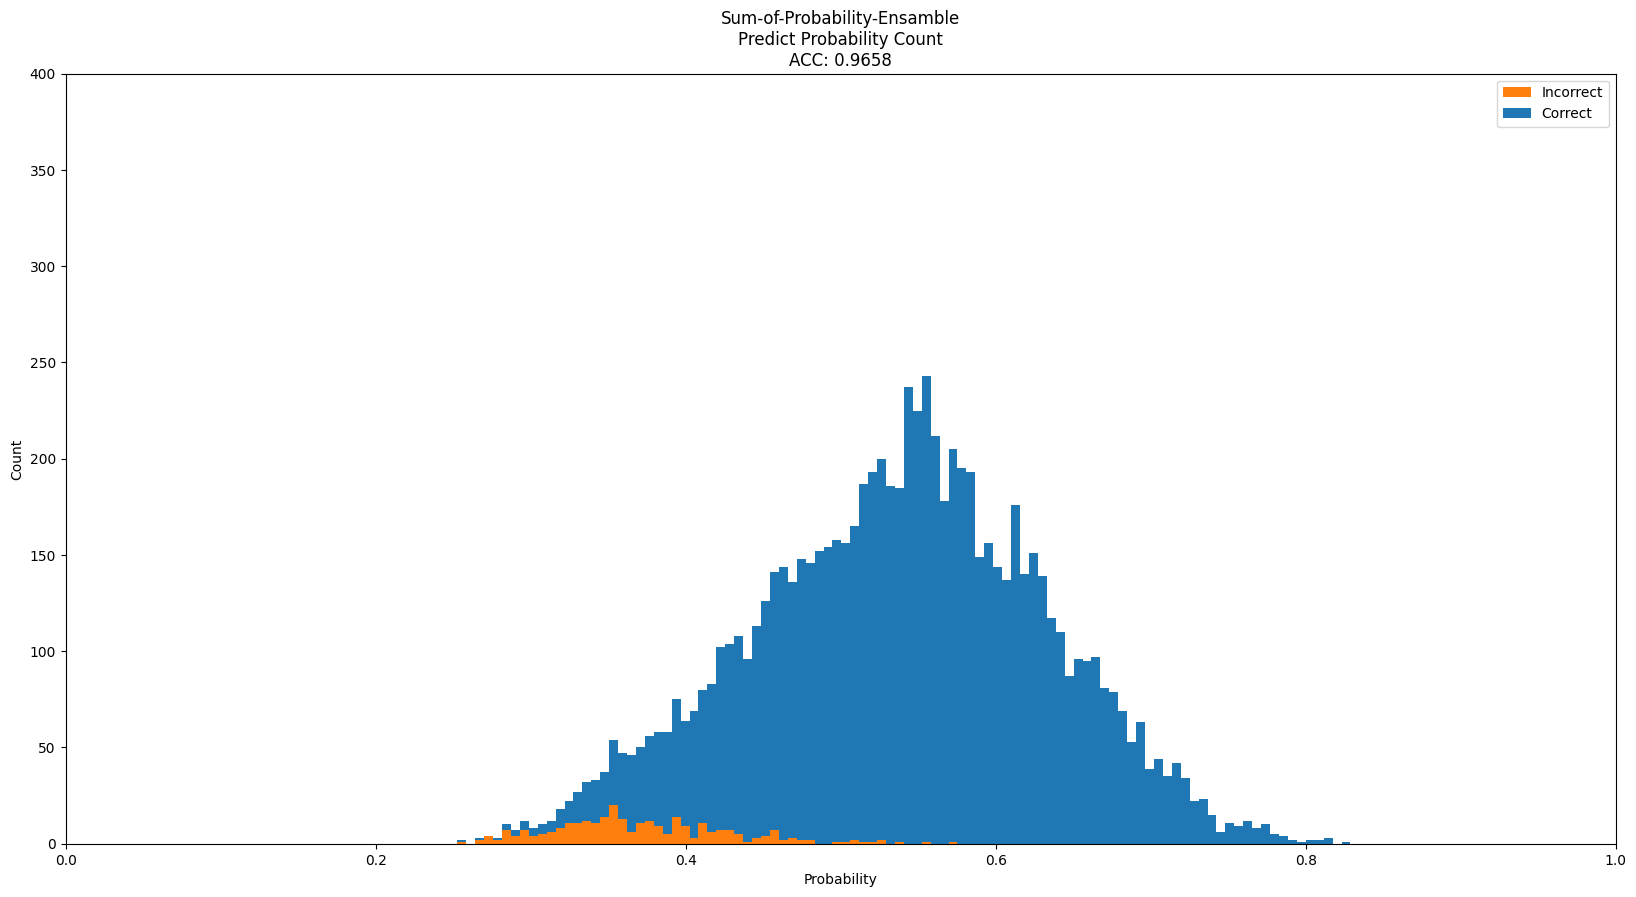

In [24]:
show_count(ensamble1_df, ensamble1_name)

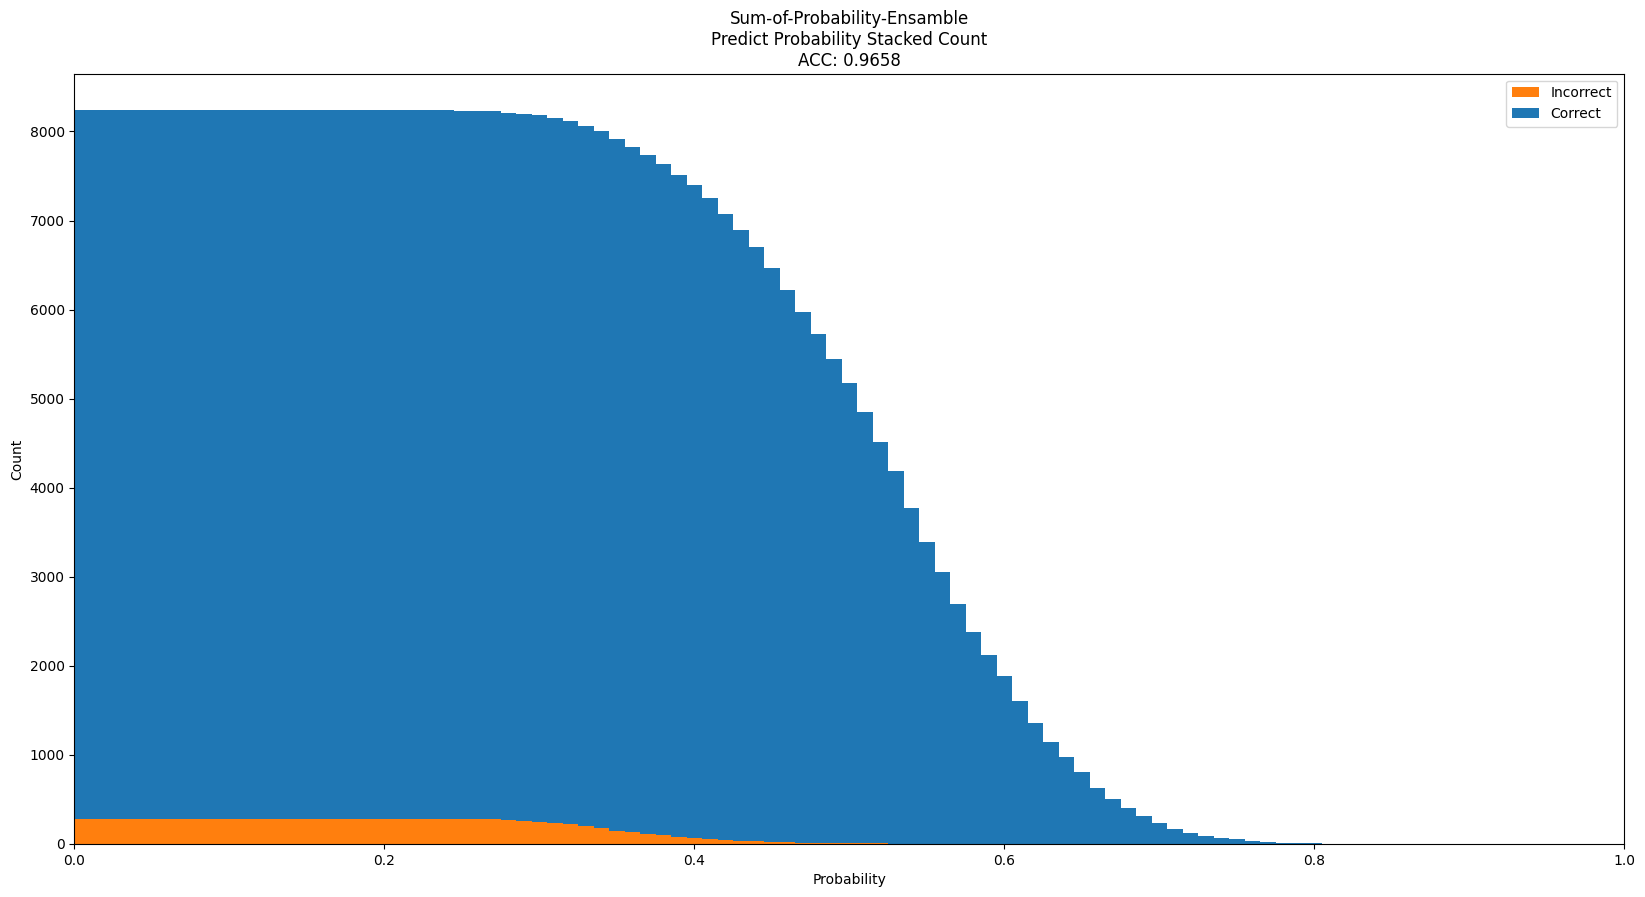

In [25]:
show_count_stacked(ensamble1_df, ensamble1_name)

In [26]:
print(f'Accuracy: {calc_accuracy(ensamble1_df):.4f}')
print(f'incorrect index num: {len(ensamble1_df.loc[ensamble1_df.true_label!=ensamble1_df.predict_label])}')
print("-"*50)
ensamble1_df.loc[ensamble1_df.predict_label!=ensamble1_df.true_label,"predict_label"].value_counts()

Accuracy: 0.9658
incorrect index num: 282
--------------------------------------------------


Upstairs      98
Downstairs    74
Walking       73
Jogging       34
Standing       3
Name: predict_label, dtype: int64

In [27]:
calc_thredshold_df(ensamble1_df)

/tmp/ipykernel_30086/1207289548.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (df['true_label'] == df['predict_label']).sum() / len(df)


,accuracy,count
threshold,,
0.0,0.965764,8237
0.1,0.965764,8237
0.2,0.965764,8237
0.3,0.969005,8195
0.4,0.990017,7513
0.5,0.997980,5446
0.6,1.000000,2121
0.7,1.000000,308
0.8,1.000000,8


## 2. Vote Ensamble

In [28]:
ensamble2_name = 'Vote-Ensamble'

In [29]:
modelnames = ["convbbt_seed314", "convbbt_seed412", "convbbt_seed752"]
ensamble2_label_df = pd.concat([convbbt_seed314_df.loc[:, "predict_label"].copy(), convbbt_seed412_df.loc[:, "predict_label"].copy(), convbbt_seed752_df.loc[:, "predict_label"].copy()], axis=1)
ensamble2_probability_df= pd.concat([convbbt_seed314_df.loc[:, "predict_probability"].copy(), convbbt_seed412_df.loc[:, "predict_probability"].copy(), convbbt_seed752_df.loc[:, "predict_probability"].copy()], axis=1)
ensamble2_label_df.columns = modelnames
ensamble2_probability_df.columns = modelnames
ensamble2_df = pd.DataFrame({
                        "predict_label": ensamble2_label_df.apply(lambda x: x.value_counts().idxmax(), axis=1),
                        "predict_probability": ensamble2_probability_df.max(axis=1),
                        "true_label": true_label.map(lambda x: LABELS[x]), "predict_probability": ensamble2_probability_df.max(axis=1),
                        })

In [30]:
ensamble2_df.head()

,predict_label,predict_probability,true_label
0,Walking,0.604218,Walking
1,Sitting,0.518753,Sitting
2,Upstairs,0.372271,Upstairs
3,Jogging,0.679431,Jogging
4,Standing,0.643581,Standing


In [31]:
value_counts = ensamble2_label_df.apply(lambda x: x.value_counts(), axis=1)

vote_3_index = value_counts.loc[(value_counts == 3).apply(lambda x: any(x), axis=1),:].index
vote_2_index = value_counts.loc[(value_counts == 2).apply(lambda x: any(x), axis=1),:].index
vote_1_index = list(set(value_counts.loc[(value_counts == 1).apply(lambda x: any(x), axis=1),:].index) - set(vote_2_index))

vote_3 = pd.DataFrame({
                "predict_label": ensamble2_label_df.loc[vote_3_index,:].apply(lambda x: x.value_counts().idxmax(), axis=1), 
                "true_label": true_label.loc[vote_3_index].map(lambda x: LABELS[x])
                })
vote_2 = pd.DataFrame({
                "predict_label": ensamble2_label_df.loc[vote_2_index,:].apply(lambda x: x.value_counts().idxmax(), axis=1), 
                "true_label": true_label.loc[vote_2_index].map(lambda x: LABELS[x])
                })
vote_1 = pd.DataFrame({
                "predict_label": ensamble2_label_df.loc[vote_1_index,:].apply(lambda x: x.value_counts().idxmax(), axis=1), 
                "true_label": true_label.loc[vote_1_index].map(lambda x: LABELS[x])
                })

In [32]:
print('All num: ', len(ensamble2_label_df))
print(f'Vote 3 num: {len(vote_3)}') 
print(f'Vote 2 num: {len(vote_2)}')
print(f'Vote 1 num: {len(vote_1)}')

All num:  8237
Vote 3 num: 7537
Vote 2 num: 644
Vote 1 num: 56


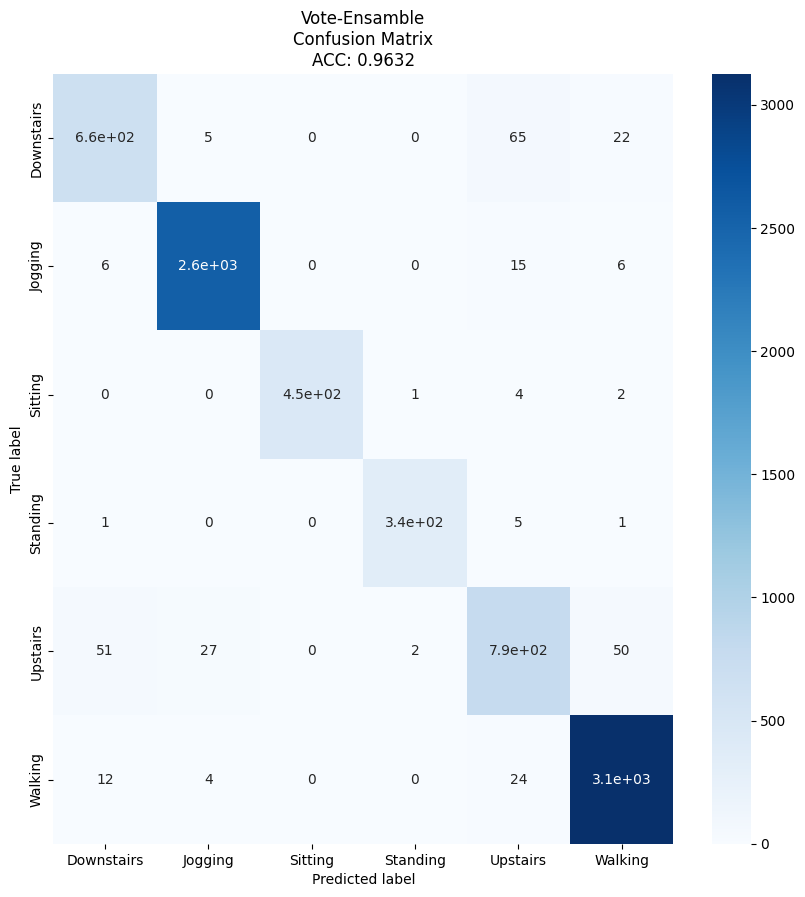

In [33]:
show_confusion_matrix(ensamble2_df, ensamble2_name)

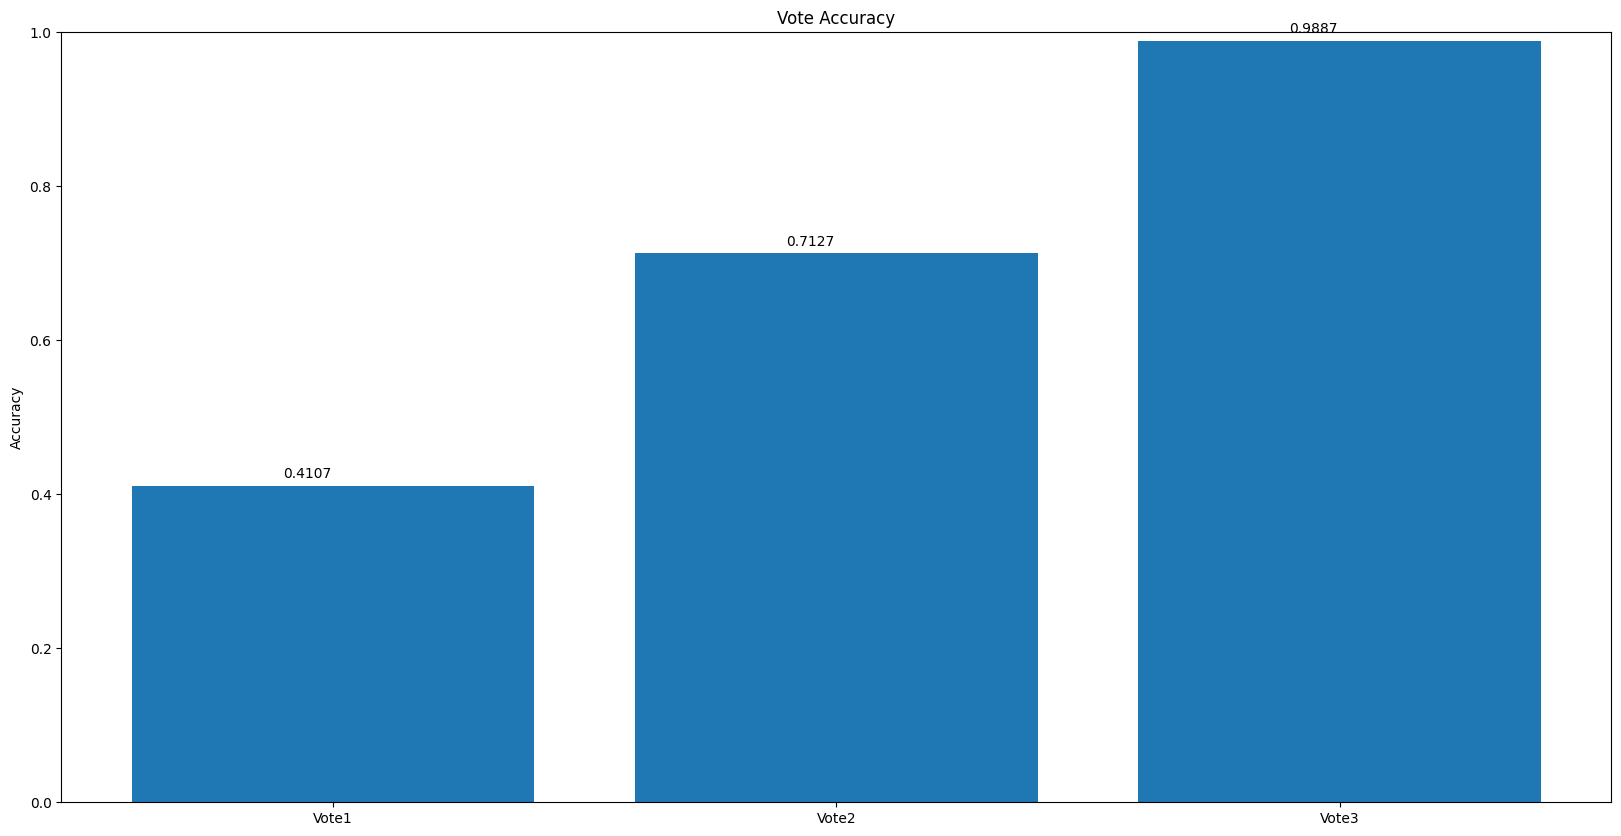

In [34]:
vote1_acc = calc_accuracy(vote_1)
vote2_acc = calc_accuracy(vote_2)
vote3_acc = calc_accuracy(vote_3)
plt.bar(["Vote1", "Vote2", "Vote3"], [vote1_acc, vote2_acc, vote3_acc])
plt.text(-0.1, vote1_acc+0.01, f'{vote1_acc:.4f}')
plt.text(0.9, vote2_acc+0.01, f'{vote2_acc:.4f}')
plt.text(1.9, vote3_acc+0.01, f'{vote3_acc:.4f}')
plt.title('Vote Accuracy')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.savefig(f'assets/{ensamble2_name}-accuracy.png')
plt.show()

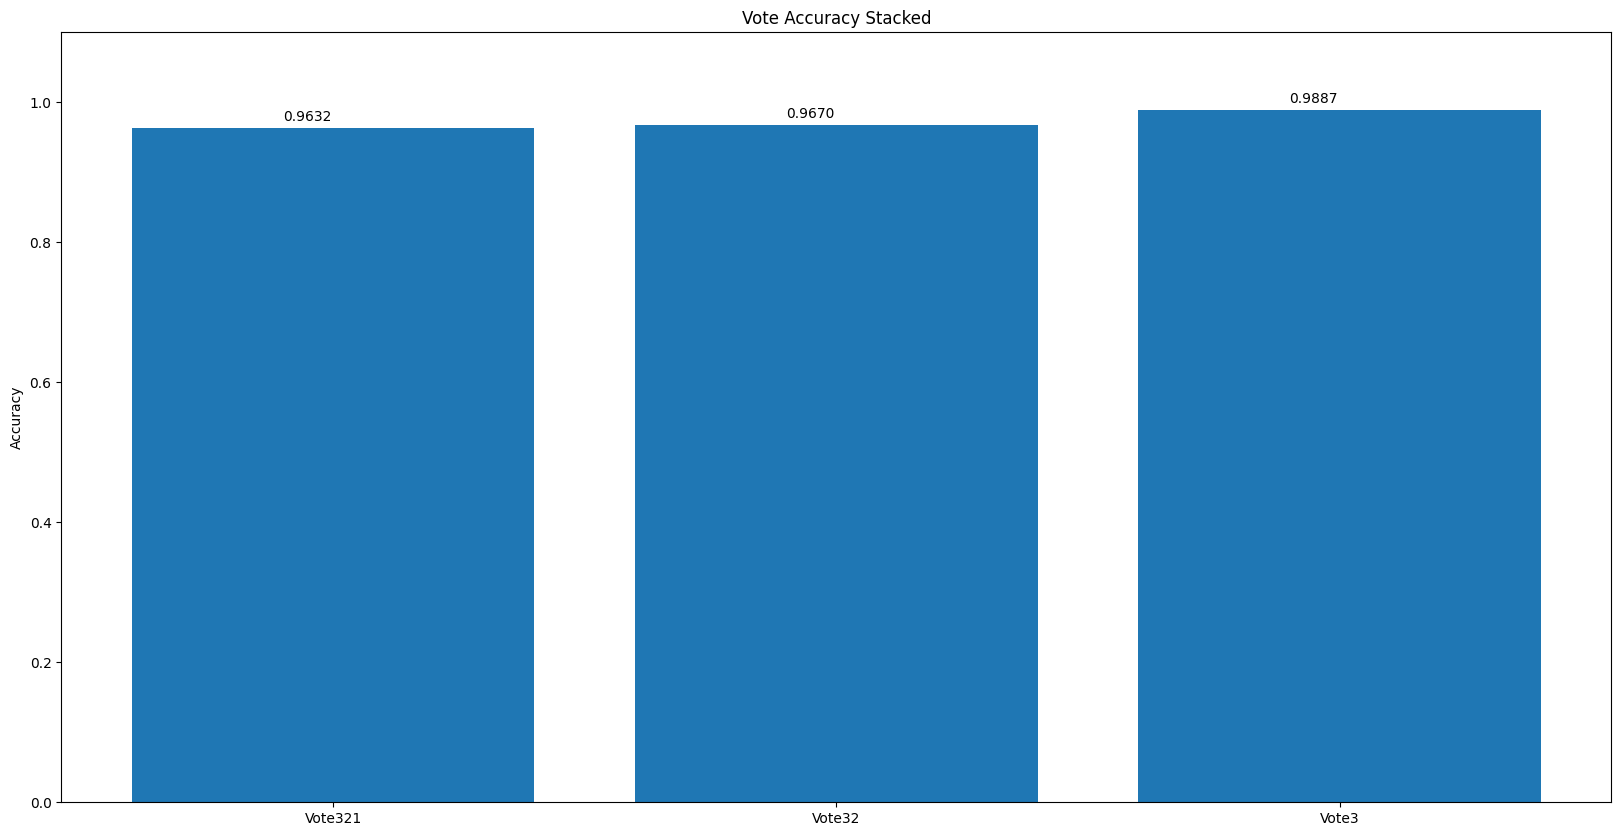

In [35]:
vote_321 = pd.concat([vote_3, vote_2, vote_1], axis=0).reset_index()
vote_32 = pd.concat([vote_3, vote_2], axis=0).reset_index()

vote_321_acc = calc_accuracy(vote_321)
vote_32_acc = calc_accuracy(vote_32)
plt.bar(["Vote321", "Vote32", "Vote3"], [vote_321_acc, vote_32_acc, vote3_acc])
plt.text(-0.1, vote_321_acc+0.01, f'{vote_321_acc:.4f}')
plt.text(0.9, vote_32_acc+0.01, f'{vote_32_acc:.4f}')
plt.text(1.9, vote3_acc+0.01, f'{vote3_acc:.4f}')
plt.title('Vote Accuracy Stacked')
plt.ylabel('Accuracy')
plt.ylim(0,1.1)
plt.savefig(f'assets/{ensamble2_name}-accuracy-stacked.png')
plt.show()


In [36]:
print(f'Accuracy: {calc_accuracy(ensamble2_df):.4f}')
print(f'incorrect index num: {len(ensamble2_df.loc[ensamble2_df.true_label!=ensamble2_df.predict_label])}')
print("-"*50)
ensamble2_df.loc[ensamble2_df.predict_label!=ensamble2_df.true_label,"predict_label"].value_counts()

Accuracy: 0.9632
incorrect index num: 303
--------------------------------------------------


Upstairs      113
Walking        81
Downstairs     70
Jogging        36
Standing        3
Name: predict_label, dtype: int64

## 3. Max of Probability Ensamble

In [37]:
ensamble3_name = 'Max-of-Probability-Ensamble'

In [38]:
modelnames = ["convbbt_seed314", "convbbt_seed412", "convbbt_seed752"]
ensamble3_label_df = pd.concat([convbbt_seed314_df.loc[:, "predict_label"].copy(), convbbt_seed412_df.loc[:, "predict_label"].copy(), convbbt_seed752_df.loc[:, "predict_label"].copy()], axis=1)
ensamble3_probability_df= pd.concat([convbbt_seed314_df.loc[:, "predict_probability"].copy(), convbbt_seed412_df.loc[:, "predict_probability"].copy(), convbbt_seed752_df.loc[:, "predict_probability"].copy()], axis=1)
ensamble3_label_df.columns = modelnames
ensamble3_probability_df.columns = modelnames
ensamble3_df = pd.DataFrame({
                        "predict_label": ensamble3_probability_df.apply(lambda x: x.idxmax(), axis=1),
                        "predict_probability": ensamble3_probability_df.max(axis=1),
                        "predict_from": ensamble3_probability_df.apply(lambda x: x.idxmax(), axis=1),
                        "true_label": true_label.map(lambda x: LABELS[x]),
                        })
refcol = ensamble3_probability_df.apply(lambda x: x.idxmax(), axis=1)
for i in range(len(ensamble3_probability_df)):
    ensamble3_df.loc[i,"predict_label"] = ensamble3_label_df.loc[i, refcol.iloc[i]]

In [39]:
ensamble3_df.head()

,predict_label,predict_probability,predict_from,true_label
0,Walking,0.604218,convbbt_seed412,Walking
1,Sitting,0.518753,convbbt_seed752,Sitting
2,Upstairs,0.372271,convbbt_seed752,Upstairs
3,Jogging,0.679431,convbbt_seed752,Jogging
4,Standing,0.643581,convbbt_seed314,Standing


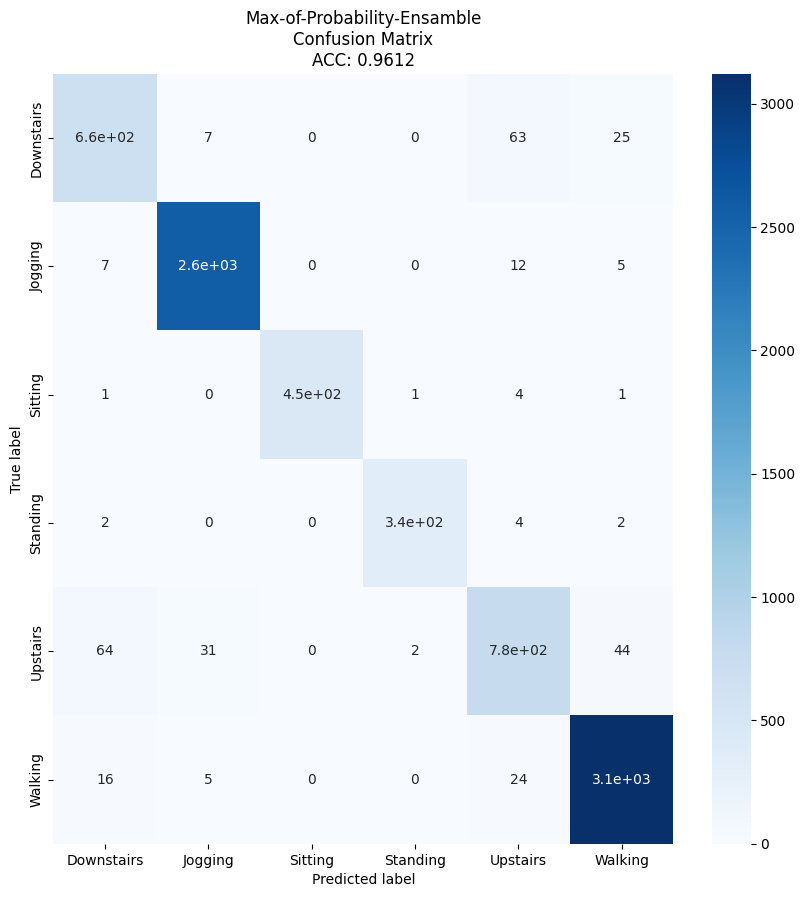

In [40]:
show_confusion_matrix(ensamble3_df, ensamble3_name)

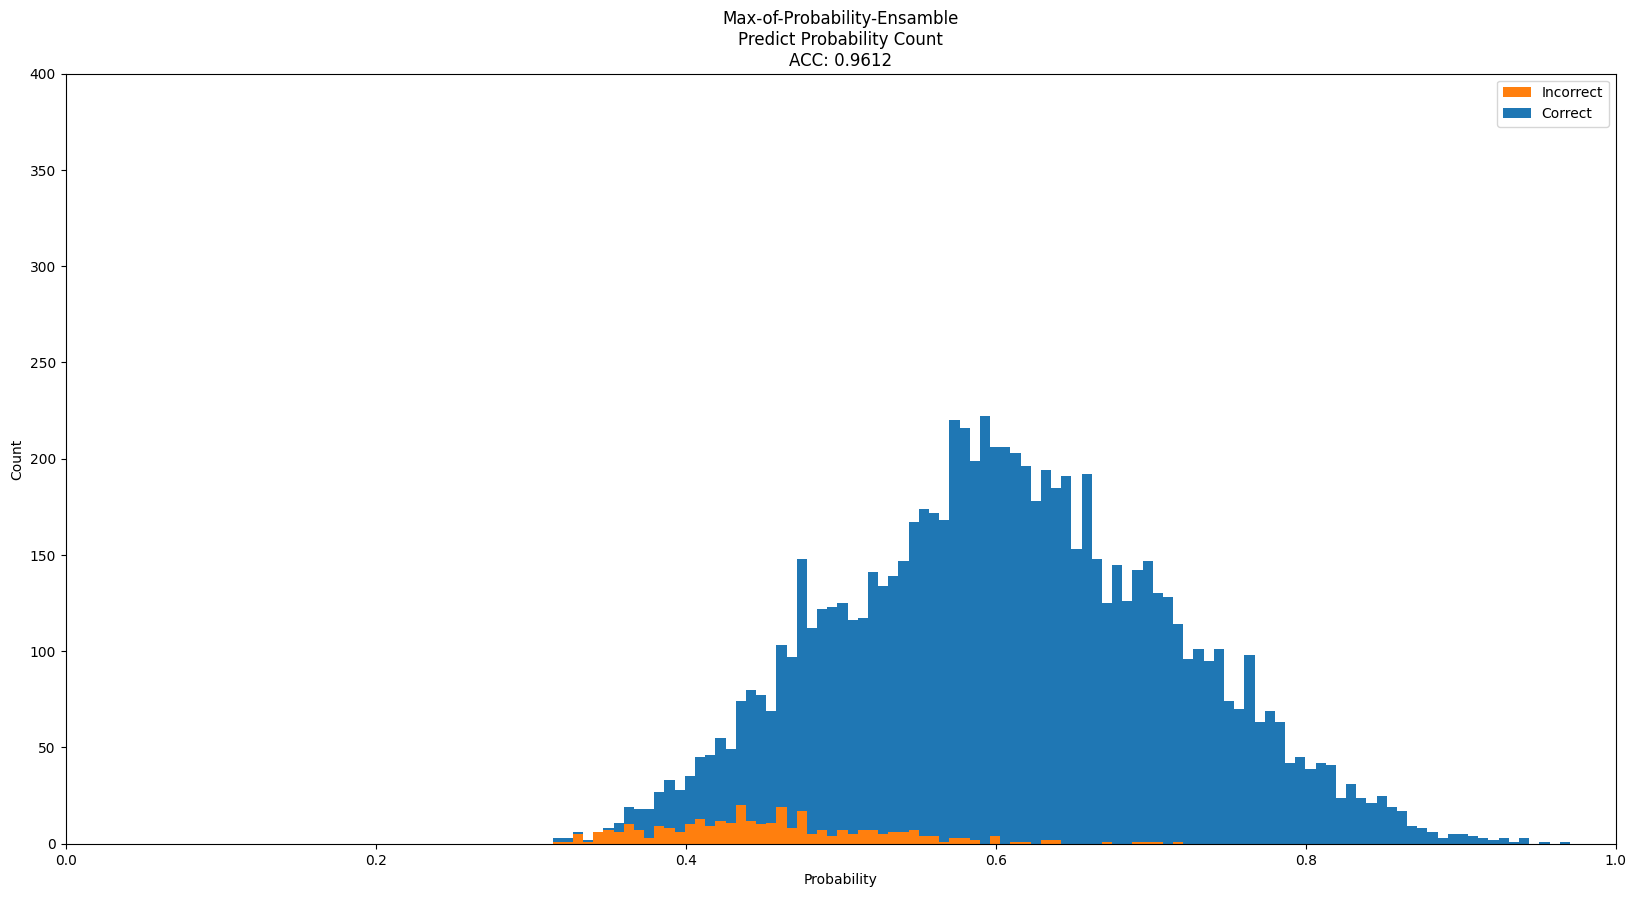

In [41]:
show_count(ensamble3_df, ensamble3_name)

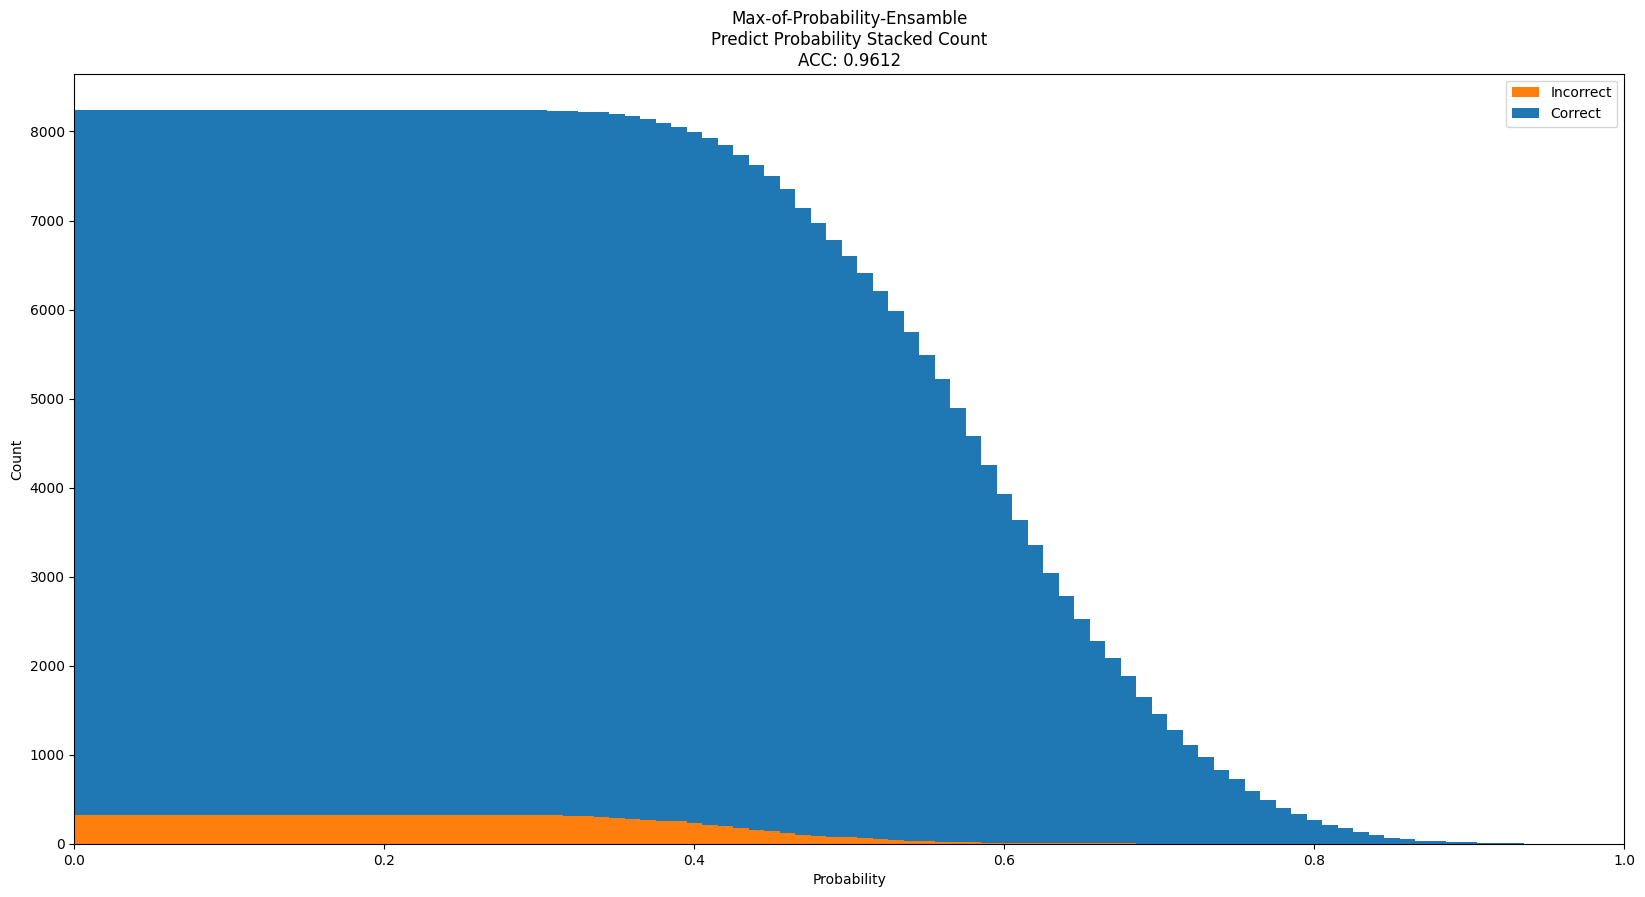

In [42]:
show_count_stacked(ensamble3_df, ensamble3_name)

In [43]:
print(f'Accuracy: {calc_accuracy(ensamble3_df):.4f}')
print(f'incorrect index num: {len(ensamble3_df.loc[ensamble3_df.true_label!=ensamble3_df.predict_label])}')
print("-"*50)
ensamble3_df.loc[ensamble3_df.predict_label!=ensamble3_df.true_label,"predict_label"].value_counts()

Accuracy: 0.9612
incorrect index num: 320
--------------------------------------------------


Upstairs      107
Downstairs     90
Walking        77
Jogging        43
Standing        3
Name: predict_label, dtype: int64

In [44]:
calc_thredshold_df(ensamble3_df)

/tmp/ipykernel_30086/1207289548.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return (df['true_label'] == df['predict_label']).sum() / len(df)


,accuracy,count
threshold,,
0.0,0.961151,8237
0.1,0.961151,8237
0.2,0.961151,8237
0.3,0.961151,8237
0.4,0.968952,8052
0.5,0.988060,6784
0.6,0.996941,4250
0.7,0.998790,1653
0.8,1.000000,335
